# Исследование данных о бронировании билетов сервиса Яндекс Афиша за период с 1 июня по 30 октября 2024 года

## Цель и задачи  

**Цель:** провести исследовательский анализ данных сервиса Яндекс Афиша, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.   

**Задачи:**
- Загрузить данные и познакомиться с ними
- Осуществить предобработку данных и подготовить их к исследованию (проверка пропусков, дубликатов, преобразование типов данных и т.д.)
- Провести исследовательский анализ данных:
  - проанализировать распределения заказов по сегментам и их сезонные изменения
  - изучить осеннюю активность пользователей
  - проанализировать популярные события и партнёров
- Провести статистический анализ данных (проверка двух гипотез)
- Сформулировать выводы по проведённому анализу


## Данные

Для анализа поступили данные сервиса Яндекс Афиша. Данные состоят из двух датасетов:
- final_tickets_orders_df.csv -  включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных
- final_tickets_events_df.csv - содержит информацию о количестве дней с предыдущей покупки для каждого пользователя

### Описание датасета "final_tickets_orders_df.csv":
- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.
- days_since_prev - количество дней с предыдущей покупки для каждого пользователя (если покупки не было, то данные содержат пропуск)

### Описание датасета "final_tickets_events_df.csv":
- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

Также есть дополнительный датасет "final_tickets_tenge_df.csv" с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.
### Описание датасета "final_tickets_tenge_df.csv":
- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

## Структура проекта
- Шаг 1. Загрузка данных и знакомство с ними
- Шаг 2. Предобработка данных и подготовка их к исследованию
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Статистический анализ данных
- Шаг 5. Общий вывод и рекомендации

## 1. Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import mannwhitneyu

In [2]:
# Загружаем данные в переменные orders_df, events_df, tenge_df
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
# Выводим информацию о датафрейме orders_df
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 290849 entries, 0 to 290848
,Data columns (total 14 columns):
, #   Column                 Non-Null Count   Dtype  
,---  ------                 --------------   -----  
, 0   order_id               290849 non-null  int64  
, 1   user_id                290849 non-null  object 
, 2   created_dt_msk         290849 non-null  object 
, 3   created_ts_msk         290849 non-null  object 
, 4   event_id               290849 non-null  int64  
, 5   cinema_circuit         290849 non-null  object 
, 6   age_limit              290849 non-null  int64  
, 7   currency_code          290849 non-null  object 
, 8   device_type_canonical  290849 non-null  object 
, 9   revenue                290849 non-null  float64
, 10  service_name           290849 non-null  object 
, 11  tickets_count          290849 non-null  int64  
, 12  total                  290849 non-null  float64
, 13  days_since_prev        268909 non-null  float64
,dtypes: float64(3), in

Датафрейм orders_df содержит 290.849 строк и 14 столбцов

In [4]:
# Выводим первые строки датафрейма orders_df
display(orders_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [5]:
# Выводим информацию о датафрейме events_df
events_df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 22427 entries, 0 to 22426
,Data columns (total 11 columns):
, #   Column                  Non-Null Count  Dtype 
,---  ------                  --------------  ----- 
, 0   event_id                22427 non-null  int64 
, 1   event_name              22427 non-null  object
, 2   event_type_description  22427 non-null  object
, 3   event_type_main         22427 non-null  object
, 4   organizers              22427 non-null  object
, 5   region_name             22427 non-null  object
, 6   city_name               22427 non-null  object
, 7   city_id                 22427 non-null  int64 
, 8   venue_id                22427 non-null  int64 
, 9   venue_name              22427 non-null  object
, 10  venue_address           22427 non-null  object
,dtypes: int64(3), object(8)
,memory usage: 1.9+ MB


Датафрейм events_df содержит 22.427 строк и 11 столбцов

In [6]:
# Выводим первые строки датафрейма events_df
display(events_df.head())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [7]:
# Выводим информацию о датафрейме tenge_df
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 357 entries, 0 to 356
,Data columns (total 4 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   data     357 non-null    object 
, 1   nominal  357 non-null    int64  
, 2   curs     357 non-null    float64
, 3   cdx      357 non-null    object 
,dtypes: float64(1), int64(1), object(2)
,memory usage: 11.3+ KB


Датафрейм tenge_df содержит 357 строк и 4 столбца

In [8]:
# Выводим первые строки датафрейма tenge_df
display(tenge_df.head())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Первичное знакомство с данными позволило сделать вывод о том, что названия столбцов соответствуют их содержанию и имеют вид snake case. Пропусков в значимых столбцах нет (только в столбце days_since_prev), значит данные загружены корректно. Следует провести работу с типами данных и их преобразованием

## 2. Предобработка данных и подготовка их к исследованию

### 2.1. Проверка данных на пропуски

Далее осуществим конвертацию валюты, и приведем данные о выручке (столбец revenue) в датафрейме df_orders в рубли

In [9]:
# Преобразуем тип данных в столбцах с датой
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [10]:
# Переименуем столбец data в created_dt_msk для дальнейшего соединения датафреймов
tenge_df.rename(columns={'data': 'created_dt_msk'}, inplace=True)

In [11]:
# Вычислим размеры датафреймов до объединения
print(orders_df.shape[0])
print(tenge_df.shape[0])

290849
,357


In [12]:
# Соединим датафреймы orders_df и tenge_df
orders_df_rub = pd.merge(orders_df, tenge_df, on='created_dt_msk', how='left')
display(orders_df_rub.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,100,19.6648,kzt


In [13]:
# Вычислим размеры датафреймов после объединения типом left
print(orders_df_rub.shape[0])

290849


In [14]:
# Конвертируем валюту
orders_df_rub['revenue_rub'] = 0.0
for i in range(len(orders_df_rub)):
    if orders_df_rub.at[i, 'currency_code']=='kzt':
        orders_df_rub.at[i, 'revenue_rub'] = orders_df_rub.at[i, 'revenue'] * orders_df_rub.at[i, 'curs']/100
    else:
        orders_df_rub.at[i, 'revenue_rub'] = orders_df_rub.at[i, 'revenue'] 
display(orders_df_rub.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,nominal,curs,cdx,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,100,18.6972,kzt,1521.94
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,100,18.3419,kzt,289.45
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,100,19.6475,kzt,1258.57
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,100,18.5010,kzt,8.49
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,100,19.6648,kzt,1390.41


In [15]:
# Считаем количество пропусков в датафрейме orders_df
orders_df_rub.isna().sum()

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
nominal                      0
curs                         0
cdx                          0
revenue_rub                  0
dtype: int64

In [16]:
# Считаем долю пропусков в датафрейме orders_df
orders_df_rub.isna().mean()

order_id                 0.000000
user_id                  0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
event_id                 0.000000
cinema_circuit           0.000000
age_limit                0.000000
currency_code            0.000000
device_type_canonical    0.000000
revenue                  0.000000
service_name             0.000000
tickets_count            0.000000
total                    0.000000
days_since_prev          0.075434
nominal                  0.000000
curs                     0.000000
cdx                      0.000000
revenue_rub              0.000000
dtype: float64

In [17]:
# Считаем количество пропусков в датафрейме events_df
events_df.isna().sum()

event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

In [18]:
# Считаем долю пропусков в датафрейме events_df
orders_df_rub.isna().mean()

order_id                 0.000000
user_id                  0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
event_id                 0.000000
cinema_circuit           0.000000
age_limit                0.000000
currency_code            0.000000
device_type_canonical    0.000000
revenue                  0.000000
service_name             0.000000
tickets_count            0.000000
total                    0.000000
days_since_prev          0.075434
nominal                  0.000000
curs                     0.000000
cdx                      0.000000
revenue_rub              0.000000
dtype: float64

В датафреймах отсутствуют пропуски (кроме столбца days_since_prev, пропуски в нем означают, что покупки не было)

In [19]:
# Отфильтруем ненужные столбцы (которые использовались для конвертации валюты)
orders_df_rub = orders_df_rub[['order_id', 'user_id', 'created_dt_msk', 
                                             'created_ts_msk', 'event_id', 'cinema_circuit',
                                            'age_limit', 'currency_code', 'device_type_canonical', 
                                             'revenue_rub', 'service_name', 'tickets_count',
                                            'total', 'days_since_prev']]

### 2.2. Изучение значений в ключевых столбцах

In [20]:
# Проверим уникальные значения в столбцах с категориальными значениями в датафрейме orders_df
print(orders_df_rub['cinema_circuit'].unique())
print(orders_df_rub['device_type_canonical'].unique())
print(orders_df_rub['service_name'].unique())
print(orders_df_rub['age_limit'].unique())

['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']
,['mobile' 'desktop']
,['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
, 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
, 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
, 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
, 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
, 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
, 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
, 'Тех билет' 'Лимоны' 'Билеты в интернете']
,[16  0 18 12  6]


В категориальных столбцах датафрейма все в порядке

In [21]:
# Проверим уникальные значения в столбцах с категориальными значениями в датафрейме events_df
print(events_df['event_type_description'].unique())
print(events_df['event_type_main'].unique())

['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
, 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
, 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
, 'снегурочка' 'подарок' 'кукольный спектакль']
,['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']


В столбце event_type_description, содержащем информацию о типе мероприятия не совсем понятна разница между "спортом" и "спортивным мероприятием"

In [22]:
# Делаем группировку по типу мероприятия и описанию
events_group = events_df.groupby('event_type_main').agg({'event_type_description': 'unique'})
display(events_group)

,event_type_description
event_type_main,
выставки,"[событие, шоу, фестиваль, спектакль]"
другое,"[шоу, цирковое шоу, событие, выставка, оперетт..."
концерты,"[концерт, фестиваль]"
спорт,"[спортивное мероприятие, спорт]"
стендап,"[шоу, спектакль, концерт, событие, фестиваль]"
театр,"[спектакль, балет, мюзикл, опера]"
ёлки,"[балет, ёлка, спектакль, опера, цирковое шоу, ..."


Далее посмотрим на распределение количественных значений и на наличие выбросов

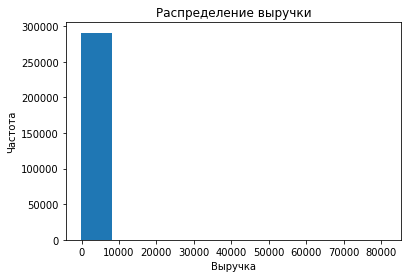

In [23]:
# Строим гистограмму распределения выручки
orders_df_rub['revenue_rub'].plot(kind='hist')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

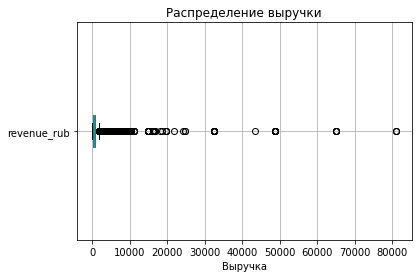

In [24]:
# Строим диаграмму размаха значений в столбце revenue_rub
orders_df_rub.boxplot(column='revenue_rub', vert=False)
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.show()

В столбце revenue_rub наблюдаются выбросы, поэтому отфильтруем значения по 99-му процентилю

In [25]:
# Считаем 99 процентиль в столбце revenue_rub
proc_99 = orders_df_rub['revenue_rub'].quantile(0.99)
print(proc_99)

2628.4217390400004


In [26]:
# Создадим копию датасета 
orders_df_99 = orders_df_rub.copy() 

In [27]:
orders_df_rub.shape[0]

290849

In [28]:
# Фильтруем данные в столбце revenue_rub по значению 99-го процентиля, чтобы избавиться от выбросов
orders_df_99 = orders_df_99[orders_df_99['revenue_rub']<proc_99]

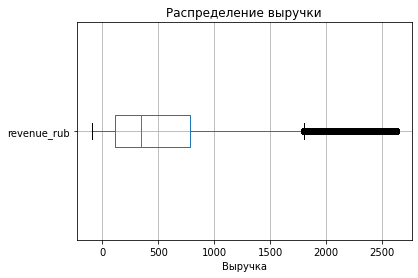

In [29]:
# Строим диаграмму размаха значений в столбце revenue_rub без учета выбросов
orders_df_99.boxplot(column='revenue_rub', vert=False)
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.show()

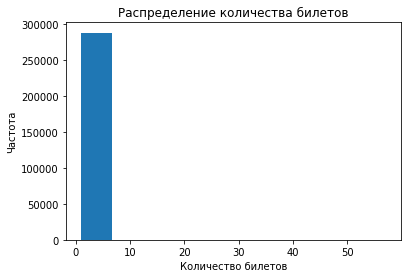

In [30]:
# Строим гистограмму распределения количества билетов
orders_df_99['tickets_count'].plot(kind='hist')
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.show()

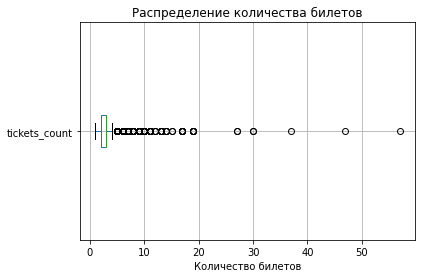

In [31]:
# Строим диаграмму размаха значений в столбце tickets_count
orders_df_99.boxplot(column='tickets_count', vert=False)
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов')
plt.show()

В столбце tickets_count наблюдаются выбросы, поэтому отфильтруем значения по 99-му процентилю

In [32]:
# Считаем 99 процентиль в столбце tickets_count
proc_99_tc = orders_df_99['tickets_count'].quantile(0.99)
print(proc_99_tc)

6.0


In [33]:
# Фильтруем данные в столбце tickets_count по значению 99-го процентиля, чтобы избавиться от выбросов
orders_df_99 = orders_df_99[orders_df_99['tickets_count']<proc_99_tc]

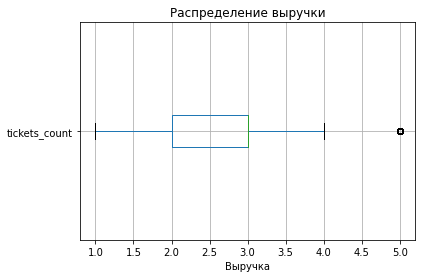

In [34]:
# Строим диаграмму размаха значений в столбце tickets_count без учета выбросов
orders_df_99.boxplot(column='tickets_count', vert=False)
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.show()

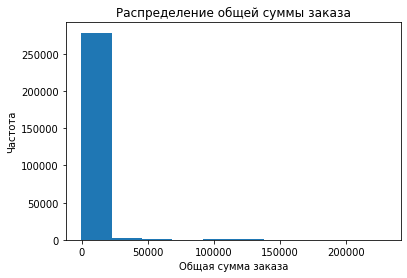

In [35]:
# Строим гистограмму распределения общей суммы заказа
orders_df_99['total'].plot(kind='hist')
plt.title('Распределение общей суммы заказа')
plt.xlabel('Общая сумма заказа')
plt.ylabel('Частота')
plt.show()

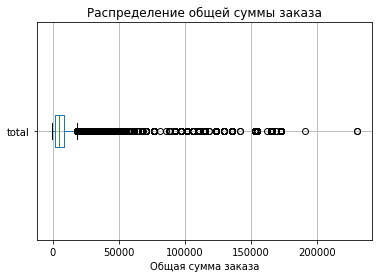

In [36]:
# Строим диаграмму размаха значений в столбце total
orders_df_99.boxplot(column='total', vert=False)
plt.title('Распределение общей суммы заказа')
plt.xlabel('Общая сумма заказа')
plt.show()

В столбце total наблюдаются выбросы, поэтому отфильтруем значения по 99-му процентилю

In [37]:
# Считаем 99 процентиль в столбце total
proc_99_total = orders_df_99['total'].quantile(0.99)
print(proc_99_total)

30823.58


In [38]:
# Фильтруем данные в столбце tickets_count по значению 99-го процентиля, чтобы избавиться от выбросов
orders_df_99 = orders_df_99[orders_df_99['total']<proc_99_total]

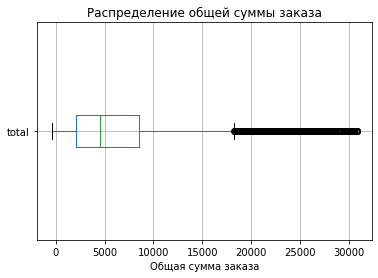

In [39]:
# Строим диаграмму размаха значений в столбце total без учета выбросов
orders_df_99.boxplot(column='total', vert=False)
plt.title('Распределение общей суммы заказа')
plt.xlabel('Общая сумма заказа')
plt.show()

In [40]:
orders_df_99.shape[0]

280668

In [41]:
delta_delete = round((1-(orders_df_99.shape[0]/orders_df_rub.shape[0]))*100,2)
print(delta_delete)

3.5


Было отфильровано 3.5% данных

### 2.3. Проверка явных и неявных дубликатов

In [42]:
# Считаем количество строк до удаления дубликатов в датафрейме orders_df_99 
before_delete_orders_df = orders_df_99.shape[0]
print(before_delete_orders_df)

280668


In [43]:
# Проверяем полные дубликаты в датафрейме orders_df_99
orders_df_99.duplicated().sum()

0

Явных дубликатов не обнаружено

In [44]:
# Проверяем неявные дубликаты по бронированию без учета идентификаторов заказа
orders_df_99.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'revenue_rub', 'service_name', 'tickets_count', 'total']).sum()

38

Было обнаружено 38 неявных дубликатов

In [45]:
# Удаляем дубликаты
orders_df_99 = orders_df_99.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'revenue_rub', 'service_name', 'tickets_count', 'total'], inplace=False)
display(orders_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [46]:
# Считаем количество строк после удаления дубликатов в датафрейме orders_df_99 
after_delete_orders_df = orders_df_99.shape[0]
print(after_delete_orders_df)

280630


In [47]:
# Считаем количество строк до удаления дубликатов в датафрейме events_df 
events_no_dubl = events_df.copy()
after_delete_events_df = events_no_dubl.shape[0]
print(after_delete_events_df)

22427


In [48]:
# Проверяем неявные дубликаты по мероприятиям без учета идентификаторов мероприятия
events_no_dubl.duplicated(subset=['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name', 'city_name', 'venue_id', 'venue_name', 'venue_address']).sum()

871

Было обнаружено 871 неявный дубликат

In [49]:
# Удаляем дубликаты
events_no_dubl = events_no_dubl.drop_duplicates(subset=['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name', 'city_name', 'venue_id', 'venue_name', 'venue_address'], inplace=False)
display(events_no_dubl.head())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [50]:
# Считаем количество строк после удаления дубликатов в датафрейме events_df 
after_delete_events_df = events_no_dubl.shape[0]
print(after_delete_events_df)

21556


Было удалено 38 неявных дубликата в датафрейме orders_df и 871 дубликат в датафрейме events_df

### 2.4. Проведение преобразования типов данных

In [51]:
# Проверим типы данных в датафрейме orders_df_99
orders_df_99.dtypes

order_id                          int64
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk                   object
event_id                          int64
cinema_circuit                   object
age_limit                         int64
currency_code                    object
device_type_canonical            object
revenue_rub                     float64
service_name                     object
tickets_count                     int64
total                           float64
days_since_prev                 float64
dtype: object

In [52]:
# Меняем тип данных в столбце created_ts_msk с информацией о дате и времени
orders_df_99['created_ts_msk'] = pd.to_datetime(orders_df_99['created_ts_msk'])

In [53]:
# Оптимизируем целочисленный тип данных в датафрейме orders_df_99
for column in ['order_id', 'event_id', 'age_limit', 'tickets_count']:
    orders_df_99[column]=pd.to_numeric(orders_df_99[column], downcast='integer')

In [54]:
# Оптимизируем вещественный тип данных в датафрейме orders_df_99
for column in ['revenue_rub', 'total', 'days_since_prev', 'revenue_rub']:
    orders_df_99[column]=pd.to_numeric(orders_df_99[column], downcast='float')

In [55]:
# Проверяем типы данных в датафрейме orders_df_99 после преобразования
orders_df_99.dtypes

order_id                          int32
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int32
cinema_circuit                   object
age_limit                          int8
currency_code                    object
device_type_canonical            object
revenue_rub                     float32
service_name                     object
tickets_count                      int8
total                           float32
days_since_prev                 float32
dtype: object

In [56]:
# Проверим типы данных в датафрейме events_df
events_no_dubl.dtypes

event_id                   int64
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int64
venue_id                   int64
venue_name                object
venue_address             object
dtype: object

In [57]:
# Оптимизируем целочисленный тип данных в датафрейме events_df
for column in ['event_id', 'city_id', 'venue_id']:
    events_no_dubl[column]=pd.to_numeric(events_df[column], downcast='integer')

In [58]:
# Проверяем типы данных в датафрейме orders_df_99 после преобразования
events_no_dubl.dtypes

event_id                   int32
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int32
venue_id                   int16
venue_name                object
venue_address             object
dtype: object

Таким образом, была проведена процедура приведения данных к более подходящему типу, а также сннижения размерности

### 2.5. Создание новых столбцов

In [59]:
# Создание нового столбца с выручкой с продажи одного билета
orders_df_99['one_ticket_revenue_rub'] = orders_df_99['revenue_rub']/orders_df_99['tickets_count']*1.0
display(orders_df_99['one_ticket_revenue_rub'].head())

0    380.484985
1    144.725006
2    314.642487
3      4.245000
4    463.470001
Name: one_ticket_revenue_rub, dtype: float32

In [60]:
# Создание нового столбца с номером месяца
orders_df_99['month'] = orders_df_99['created_dt_msk'].dt.month
display(orders_df_99[['created_dt_msk', 'month']].head())

,created_dt_msk,month
0,2024-08-20,8
1,2024-07-23,7
2,2024-10-06,10
3,2024-07-13,7
4,2024-10-04,10


In [61]:
# Создание нового столбца с названием сезона
def type_season(mon):
        if mon in [6,7,8]:
            return 'лето'
        elif mon in [9,10,11]:
            return 'осень'
        elif mon in [3,4,5]:
            return 'весна'
        elif mon in [1,2,12]:
            return 'зима'
orders_df_99['season'] = orders_df_99['month'].apply(type_season)
display(orders_df_99[['month', 'season']].head())

,month,season
0,8,лето
1,7,лето
2,10,осень
3,7,лето
4,10,осень


### 2.6. Промежуточный вывод

In [62]:
delele_orders_df = round((1-(orders_df_99.shape[0]/orders_df_rub.shape[0]))*100,2)
delete_events_df = round((1-(events_no_dubl.shape[0]/events_df.shape[0]))*100,2)
print(f'В датафрейме order_df_rub отфильтровано {delele_orders_df}% данных')
print(f'В датафрейме events_df отфильтровано {delete_events_df}% данных')

В датафрейме order_df_rub отфильтровано 3.51% данных
,В датафрейме events_df отфильтровано 3.88% данных


В процессе предобработки данных были выполнены следующие действия:
- были проверены пропуски в датафреймах, их не было обнаружено
- было изучено распределение количественных значений и наличие выбросов, вследствие чего  столбцы revenue_rub, tickets_count, total датарфейма orders_df были отфильтрованы по 99му процентилю, так как содержали выбросы
- были проверены дубликаты, вследствие чего было удалено 38 неявных дубликатов в датафрейме orders_df и 871 неявный дубликат в датафрейме events_df
- были преобразованы типы данных: в столбцах created_ts_msk, created_dt_msk тип данных был изменен на datetime64; в столбцах с целочисленными и вещественными типами была снижена размерность 
- было создано несколько новых столбцов: revenue_rub с выручкой в рублях, one_tickets_revenue_rub с выручкой с продажи одного билета, month с номером месяца, season с названием сезона

## 3. Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

In [63]:
# Соединяем датафреймы orders_df_99 и events_df
df = orders_df_99.merge(events_no_dubl, how='left', on='event_id')
display(df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue_rub,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


#### 3.1.1. Нахождение количества заказов для каждого месяца

In [64]:
# Группируем данные по месяцу по количеству заказов
counts_orders = df.groupby('month')['order_id'].count()
display(counts_orders)

month
6     31622
7     39605
8     43608
9     68194
10    97601
Name: order_id, dtype: int64

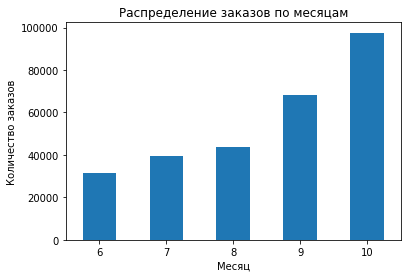

In [65]:
# Строим столбчатую диаграмму распределения количества заказов по месяцам
counts_orders.plot(kind='bar', title='Распределение заказов по месяцам', xlabel='Месяц', ylabel='Количество заказов', rot=0)
plt.show()

Наблюдается заметное увеличение заказов от июня к ноябрю 

#### 3.1.2. Сравнение распределения заказов билетов для осеннего и летнего периодов

In [66]:
# Группируем данные по сезону и по типу мероприятия по количеству заказов
sum_aut_event = df.groupby(['event_type_main', 'season'])['order_id'].count().unstack(fill_value=0)
display(sum_aut_event)

season,лето,осень
event_type_main,,
выставки,2400,2423
другое,30423,30486
концерты,46434,60677
спорт,2587,17339
стендап,6213,6783
театр,22479,40506
ёлки,268,1632


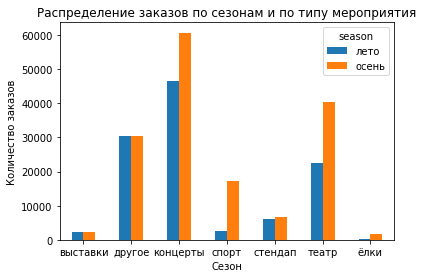

In [67]:
# Строим столбчатую диграмму распределения заказов по сезонам и по типу мероприятия
sum_aut_event.plot(kind='bar', title='Распределение заказов по сезонам и по типу мероприятия', 
                   xlabel='Сезон', ylabel='Количество заказов', rot=0)
plt.show()

In [68]:
# группируем данные по сезону и типу устройства по количеству заказов
sum_aut_device = df.groupby(['device_type_canonical', 'season'])['order_id'].count().unstack(fill_value=0)
display(sum_aut_device)

season,лето,осень
device_type_canonical,,
desktop,21778,33571
mobile,93057,132224


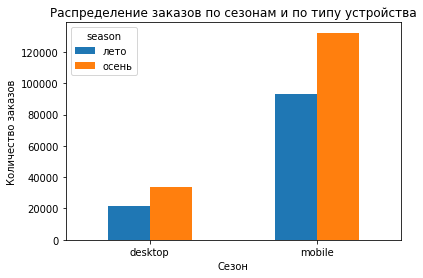

In [69]:
# строим столбчатую диаграмму распределения заказов по сезонам и по типу устройства
sum_aut_device.plot(kind='bar', title='Распределение заказов по сезонам и по типу устройства', 
                   xlabel='Сезон', ylabel='Количество заказов', rot=0)
plt.show()

In [70]:
# группируем данные по возрастному ограничению и по сезонам по количеству заказов
sum_aut_age = df.groupby(['age_limit', 'season'])['order_id'].count().unstack(fill_value=0)
display(sum_aut_age)

season,лето,осень
age_limit,,
0,20860,38859
6,21450,29365
12,22859,36542
16,32086,43785
18,17580,17244


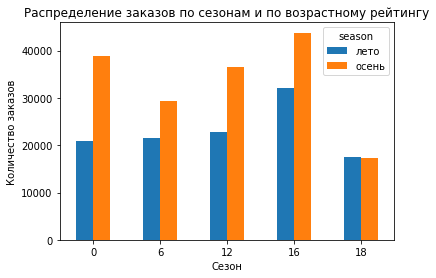

In [71]:
# строим столбчатую диаграмму распределение заказов по сезонам и по возрастному рейтингу
sum_aut_age.plot(kind='bar', title='Распределение заказов по сезонам и по возрастному рейтингу', 
                   xlabel='Сезон', ylabel='Количество заказов', rot=0)
plt.show()

#### 3.1.3. Изучение изменения выручки с продажи одного билета

In [72]:
# группируем данные по типу мероприятия и сезону по средней выручке с продажи одного билета
avg_revenue_ticket = df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack(fill_value=0)
display(avg_revenue_ticket)

season,лето,осень
event_type_main,,
выставки,86.421577,90.706734
другое,77.247368,77.452606
концерты,291.201324,267.384857
спорт,52.866016,50.891445
стендап,219.432327,232.389191
театр,218.368454,178.918060
ёлки,273.779510,232.952698


In [73]:
# считаем относительное изменение осенних значений по сравнению с летними
avg_revenue_ticket['delta_percent'] = avg_revenue_ticket['осень']-avg_revenue_ticket['лето']
display(avg_revenue_ticket)

season,лето,осень,delta_percent
event_type_main,,,
выставки,86.421577,90.706734,4.285156
другое,77.247368,77.452606,0.205238
концерты,291.201324,267.384857,-23.816467
спорт,52.866016,50.891445,-1.974571
стендап,219.432327,232.389191,12.956863
театр,218.368454,178.918060,-39.450394
ёлки,273.779510,232.952698,-40.826813


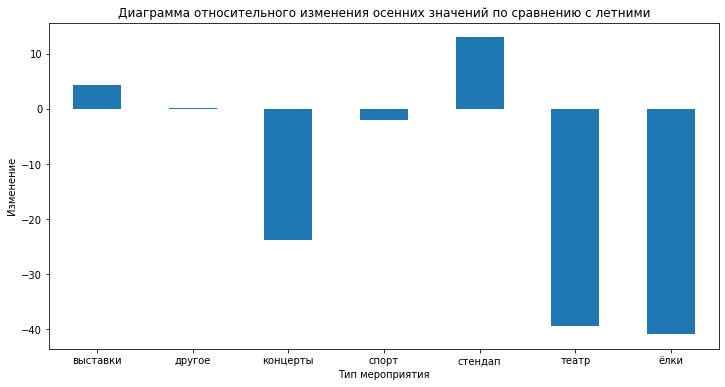

In [74]:
# строим столбчатую диаграмму по относительному изменению осенних значений по сравнению с летними
avg_revenue_ticket['delta_percent'].plot(kind='bar', title='Диаграмма относительного изменения осенних значений по сравнению с летними', 
                   xlabel='Тип мероприятия', ylabel='Изменение', rot=0, figsize=(12,6))
plt.show()

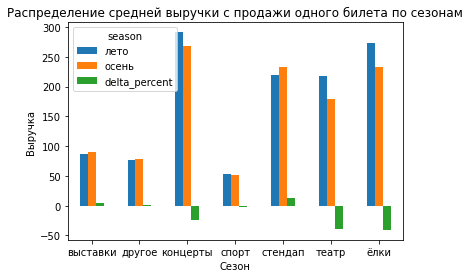

In [75]:
# строим столбчатую диаграмму распределения по средней выручке с продажи одного билета
avg_revenue_ticket.plot(kind='bar', title='Распределение средней выручки с продажи одного билета по сезонам', 
                   xlabel='Сезон', ylabel='Выручка', rot=0)
plt.show()

In [76]:
# считаем относительное изменение осенних значений по сравнению с летними
avg_revenue_ticket['share'] = avg_revenue_ticket['осень']/avg_revenue_ticket['лето']
display(avg_revenue_ticket)

season,лето,осень,delta_percent,share
event_type_main,,,,
выставки,86.421577,90.706734,4.285156,1.049584
другое,77.247368,77.452606,0.205238,1.002657
концерты,291.201324,267.384857,-23.816467,0.918213
спорт,52.866016,50.891445,-1.974571,0.962650
стендап,219.432327,232.389191,12.956863,1.059047
театр,218.368454,178.918060,-39.450394,0.819340
ёлки,273.779510,232.952698,-40.826813,0.850877


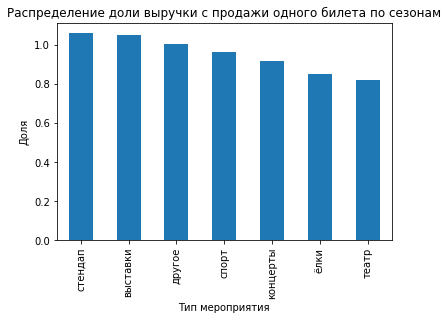

In [77]:
# строим столбчатую диаграмму распределения доли выручки с продажи одного билета по сезонам
avg_revenue_ticket = avg_revenue_ticket.sort_values(by='share', ascending=False)
avg_revenue_ticket['share'].plot(kind='bar', title='Распределение доли выручки с продажи одного билета по сезонам', 
                   xlabel='Тип мероприятия', ylabel='Доля')
plt.show()

#### 3.1.4. Промежуточный вывод

Изменение средней стоимости одного билета в разрезе разных типов мероприятий наблюдается: значение увеличилось у таких типов мероприятий, как выставки, другое и стендап, а у концертов, спорта, театра и елок значение уменьшилось  
Расчет относительного изменения осенних значений по сравнению с летними показал, что наибольшая доля принадлежит стендапам (1,06), наименьшая - театрам (0,82). Это означает, что средняя доля выручки имеет наибольшее изменение именно у стендапов, а наименьшее - у театров

### 3.2. Изучение осенней активности пользователей

In [78]:
# создаем копию датафрейма
df_autumn = df.copy()

In [79]:
# фильтруем датафрейм, оставляя данные только по осени
df_autumn = df_autumn[df_autumn['season']=='осень']

#### 3.2.1. Анализ динамики изменения метрик по дням

In [80]:
# группируем данные по дате заказа по количеству заказов и пользователей, средней стоимости одного билета
group_autumn = df_autumn.groupby('created_dt_msk').agg({'order_id': 'count', 'user_id': 'nunique', 'one_ticket_revenue_rub': 'mean'})
display(group_autumn)

,order_id,user_id,one_ticket_revenue_rub
created_dt_msk,,,
2024-09-01,1304,558,201.787689
2024-09-02,1352,564,188.001419
2024-09-03,4980,764,80.491524
2024-09-04,1729,670,176.278320
2024-09-05,1895,722,187.691269
...,...,...,...
2024-10-27,2818,1025,187.699860
2024-10-28,2798,973,171.890289
2024-10-29,2801,995,179.059280


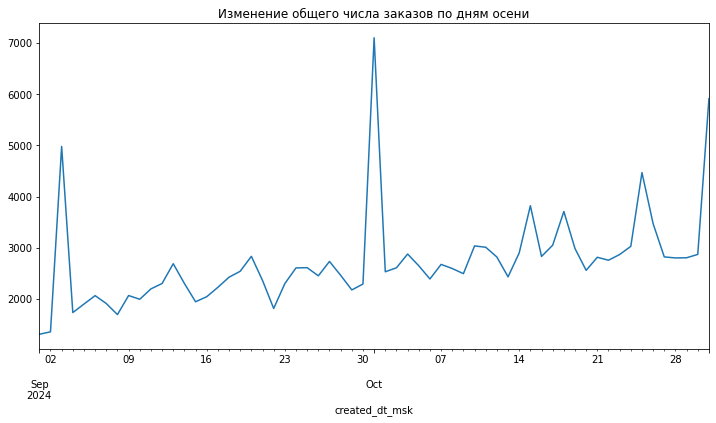

In [81]:
# строим линейный график изменения общего числа заказов по дням осени
group_autumn['order_id'].plot(kind='line', title='Изменение общего числа заказов по дням осени', 
                              x='День', y='Количество заказов', figsize=(12,6))
plt.show()

Значение общего числа заказов достигло наибольшего значения (6.850) 1 октября, наименьшее значение (746) было зафиксировано 1 сентября. На протяжении всего периода метрика в целом довольно стабильна, находилась в районе 2000-4000. Резкий подъем замечен в последний день (5.663). 

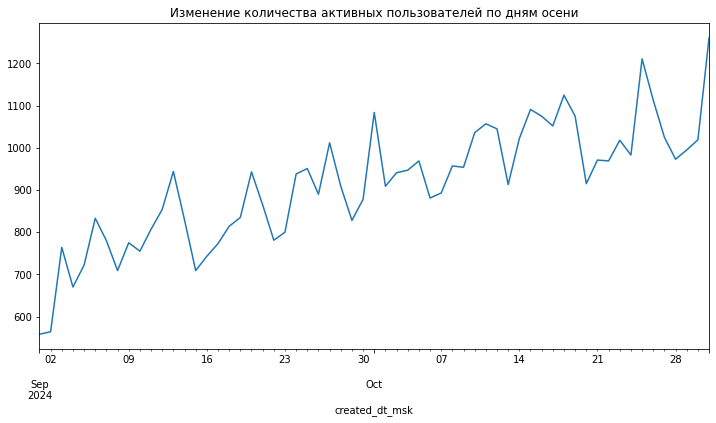

In [82]:
# строим линейный график изменения количества активных пользователей по дням осени
group_autumn['user_id'].plot(kind='line', title='Изменение количества активных пользователей по дням осени', 
                              x='День', y='Количество пользователей', figsize=(12,6))
plt.show()

Линейный график изменения количества активных пользователей позволил сделать следующие выводы: на протяжении всего периода значение увеличивалось, достигнув максимального значения (1.105) в последний день. Минимальное значение (218) принадлежит первому дню. 

In [83]:
# считаем среднее количество заказов на одного пользователя 
group_autumn['count_orders_one_user'] = group_autumn['order_id']/group_autumn['user_id']*1.0
display(group_autumn)

,order_id,user_id,one_ticket_revenue_rub,count_orders_one_user
created_dt_msk,,,,
2024-09-01,1304,558,201.787689,2.336918
2024-09-02,1352,564,188.001419,2.397163
2024-09-03,4980,764,80.491524,6.518325
2024-09-04,1729,670,176.278320,2.580597
2024-09-05,1895,722,187.691269,2.624654
...,...,...,...,...
2024-10-27,2818,1025,187.699860,2.749268
2024-10-28,2798,973,171.890289,2.875642
2024-10-29,2801,995,179.059280,2.815075


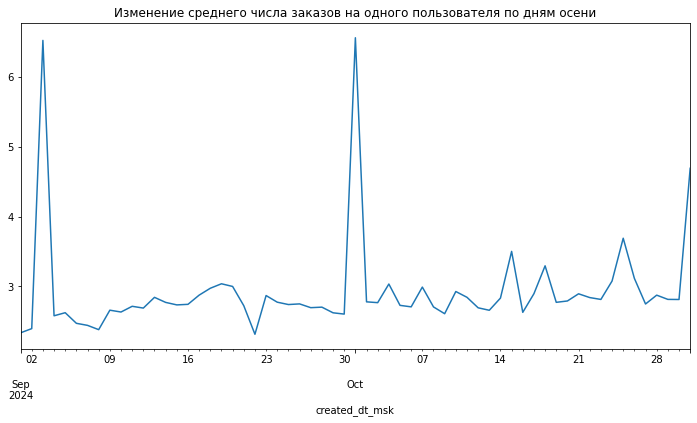

In [84]:
# строим линейный график изменения среднего числа заказов на одного пользователя по дням осени
group_autumn['count_orders_one_user'].plot(kind='line', title='Изменение среднего числа заказов на одного пользователя по дням осени', 
                              x='День', y='Среднее число заказов на одного пользователя', figsize=(12,6))
plt.show()

Линейный график среднего числа заказов на одного пользователя имеет два пика: 3 сентября (10.57) и 1 октября (7.57).

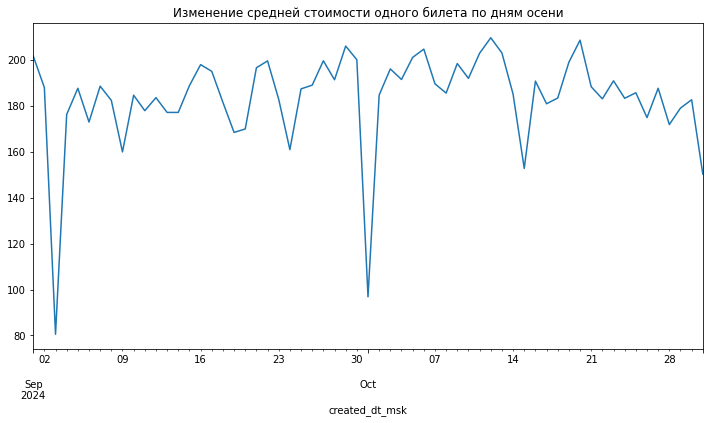

In [85]:
# строим линейный график изменения средней стоимости одного билета по дням осени
group_autumn['one_ticket_revenue_rub'].plot(kind='line', title='Изменение средней стоимости одного билета по дням осени',
                               x='День', y='Средняя стоимость одного билета', figsize=(12,6))
plt.show()

Линейный график средней стоимости одного билета демонстрирует 2 очень резких спада, они приходятся на 3 сентября и 1 октября

#### 3.2.2. Изучение недельной цикличности

In [86]:
# выделяем название дня недели из даты заказа
df_autumn['day_of_week'] = df_autumn['created_dt_msk'].dt.day_name()
display(df_autumn[['created_dt_msk', 'day_of_week']])

,created_dt_msk,day_of_week
2,2024-10-06,Sunday
4,2024-10-04,Friday
5,2024-10-23,Wednesday
7,2024-09-29,Sunday
8,2024-10-15,Tuesday
...,...,...
280625,2024-10-27,Sunday
280626,2024-10-27,Sunday
280627,2024-10-30,Wednesday
280628,2024-09-24,Tuesday


In [87]:
# группируем данные по дню недели и считаем количество заказов и пользователей, средней стоимости одного билета
group_weeks = df_autumn.groupby('day_of_week').agg({'order_id': 'count', 'user_id': 'nunique', 'one_ticket_revenue_rub': 'mean'})
display(group_weeks)

,order_id,user_id,one_ticket_revenue_rub
day_of_week,,,
Friday,24359,4799,185.899490
Monday,21212,4405,184.726974
Saturday,20929,4514,192.220688
Sunday,19101,4336,198.423294
Thursday,26802,4919,177.449142
Tuesday,30867,4742,141.862091
Wednesday,22525,4761,186.205154


In [88]:
# считаем среднее количество заказов на одного пользователя 
group_weeks['count_orders_one_user'] = group_weeks['order_id']/group_weeks['user_id']*1.0
display(group_weeks)

,order_id,user_id,one_ticket_revenue_rub,count_orders_one_user
day_of_week,,,,
Friday,24359,4799,185.899490,5.075849
Monday,21212,4405,184.726974,4.815437
Saturday,20929,4514,192.220688,4.636464
Sunday,19101,4336,198.423294,4.405212
Thursday,26802,4919,177.449142,5.448668
Tuesday,30867,4742,141.862091,6.509279
Wednesday,22525,4761,186.205154,4.731149


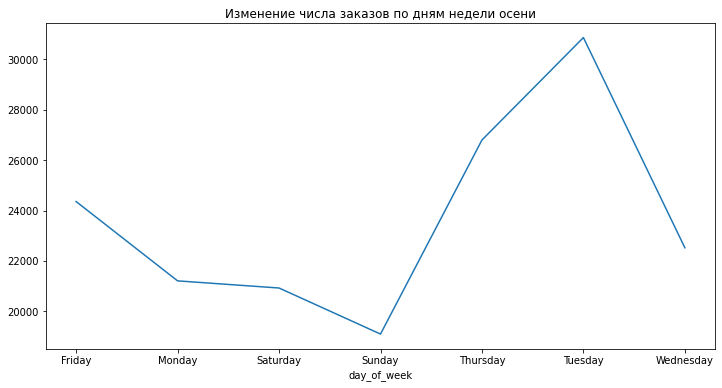

In [89]:
# строим линейный график изменения числа заказов по дням недели осени
group_weeks['order_id'].plot(kind='line', title='Изменение числа заказов по дням недели осени', 
                     x='День недели', y='Средняя стоимость одного билета', figsize=(12,6))
plt.show()

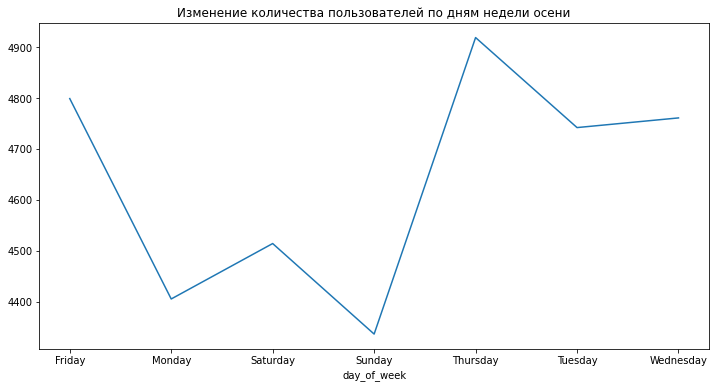

In [90]:
# строим линейный график изменения количества пользователей по дням недели осени
group_weeks['user_id'].plot(kind='line', title='Изменение количества пользователей по дням недели осени', 
                     x='День недели', y='Количество пользователей', figsize=(12,6))
plt.show()

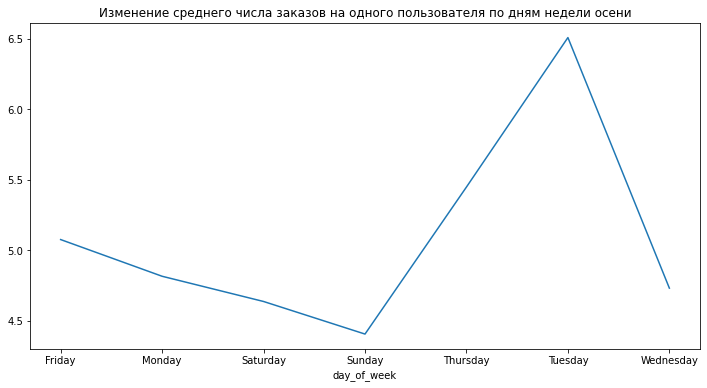

In [91]:
# строим линейный график изменения среднего числа заказов на одного пользователя по дням недели осени
group_weeks['count_orders_one_user'].plot(kind='line', title='Изменение среднего числа заказов на одного пользователя по дням недели осени', 
                     x='День недели', y='Среднее число заказов на одного пользователя', figsize=(12,6))
plt.show()

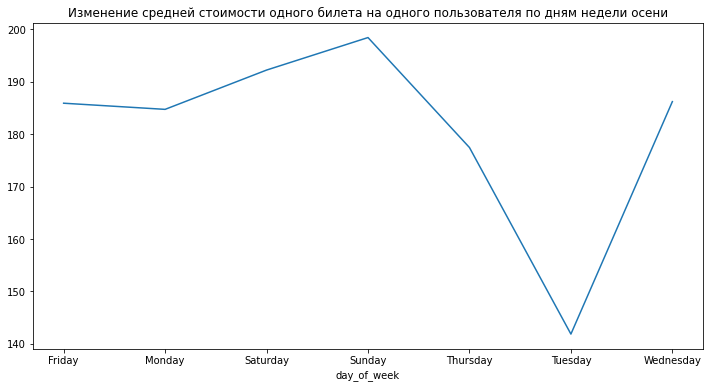

In [92]:
# строим линейный график изменения средней стоимости одного билета на одного пользователя по дням недели осени
group_weeks['one_ticket_revenue_rub'].plot(kind='line', title='Изменение средней стоимости одного билета на одного пользователя по дням недели осени', 
                     x='День недели', y='Средняя стоимость одного билета', figsize=(12,6))
plt.show()

#### 3.2.3. Промежуточный вывод

Наибольшее число заказов (30.867) наблюдается во вторник (будний день), наименьшее (19.101) - в воскресенье (выходной день). Больше всего пользователей (4.919) замечено в четверг (будний день), меньше всего (4.336) - снова в воскресенье (выходной день). Далее логично, что среднее число заказов на одного пользователя наибольшее (6,5) во вторник, наименьшее (4,4) - в воскресенье. А в ситуации со средней стоимостью одного билета на одного пользователя результаты обратные, самое высокое значение (198,42) зафиксировано в воскресенье, тогда как самое низкое (141,86) - во вторник
Низкая активность в воскресенье может быть связана с тем, что это выходной день, и люди предпочитают отдыхать дома или в других местах, не посещая различные мероприятия. Поэтому можно было бы ввести специальные предложения с целью повысить активность пользователей 

### 3.3. Изучение популярных событий и партнёров

In [93]:
# группируем данные по региону по количеству мероприятия и заказов
group_regions = df.groupby('region_name').agg({'event_id': 'nunique', 'order_id': 'count'})
# сортируем по количеству мероприятий по убыванию
group_regions =group_regions.sort_values(by='event_id', ascending=False)
# считаем долю мероприятий от общего количества
group_regions['share_evenets'] = group_regions['event_id']/df['event_id'].nunique()
# считаем долю заказов от общего количества
group_regions['share_orders'] = group_regions['order_id']/df['order_id'].count()
display(group_regions)

,event_id,order_id,share_evenets,share_orders
region_name,,,,
Каменевский регион,5671,85375,0.254922,0.304226
Североярская область,3666,42057,0.164794,0.149866
Широковская область,1171,15088,0.052639,0.053765
Светополянский округ,1044,7331,0.046930,0.026123
Речиновская область,688,6058,0.030927,0.021587
...,...,...,...,...
Теплоозёрский округ,2,7,0.000090,0.000025
Сосноводолинская область,2,10,0.000090,0.000036
Лесноярский край,2,19,0.000090,0.000068


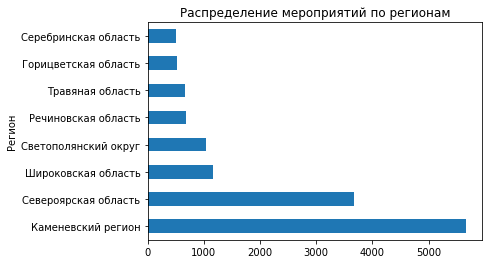

In [94]:
# строим столбчатую диаграмму распределения мероприятий по регионам
group_regions['event_id'][0:8].plot(kind='barh', title='Распределение мероприятий по регионам', 
                                    xlabel='Регион', ylabel='Количество мероприятий')
plt.show()

In [95]:
# группируем данные по названию площадки и считаем количество мероприятий и заказов, сумму выручки
group_venue = df.groupby('venue_name').agg(
    {'event_id': 'nunique', 'order_id': 'count', 'revenue_rub': 'sum'})
# сортируем по количеству мероприятий по убыванию
group_venue =group_venue.sort_values(by='event_id', ascending=False)
# считаем долю мероприятий от общего количества
group_venue['share_evenets'] = group_venue['event_id']/df['event_id'].nunique()
# считаем долю заказов от общего количества
group_venue['share_orders'] = group_venue['order_id']/df['order_id'].count()
group_venue['revenue_rub'] = group_venue['revenue_rub'].round()
display(group_venue)

,event_id,order_id,revenue_rub,share_evenets,share_orders
venue_name,,,,,
"Фестивальный проект ""Листья"" Групп",276,2649,2045794.0,0.012407,0.009439
"Дворец культуры ""Скворечник"" Инк",276,2980,864627.0,0.012407,0.010619
"Творческое объединение ""Гармония"" Инк",177,968,639549.0,0.007956,0.003449
"Совет искусства ""Шар"" и партнеры",164,1778,1206885.0,0.007372,0.006336
"Студия анимации ""Fusion"" Групп",137,1335,768848.0,0.006158,0.004757
...,...,...,...,...,...
"Летний лагерь искусств ""Синие"" Лтд",1,2,177.0,0.000045,0.000007
"Летний лагерь искусств ""Модуль"" Групп",1,23,10336.0,0.000045,0.000082
"Летний лагерь искусств ""Лунарий"" Групп",1,4,2505.0,0.000045,0.000014


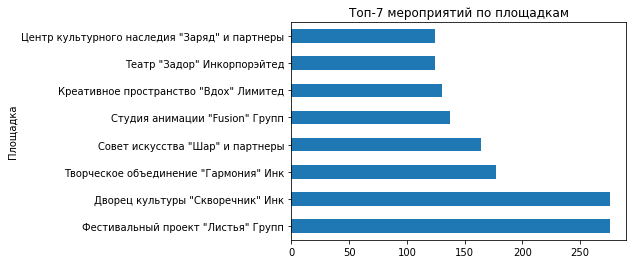

In [96]:
# строим столбчатую диаграмму распределения мероприятий по площадкам
group_venue['event_id'][0:8].plot(kind='barh', title='Топ-7 мероприятий по площадкам', 
                                    xlabel='Площадка', ylabel='Количество мероприятий')
plt.show()

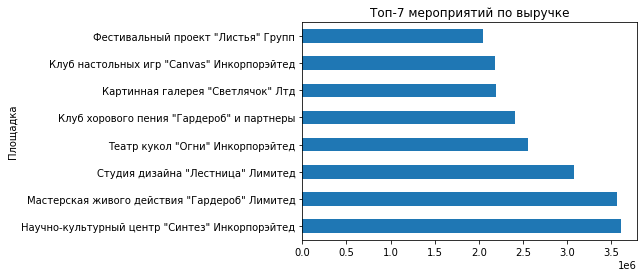

,event_id,order_id,revenue_rub,share_evenets,share_orders
venue_name,,,,,
"Научно-культурный центр ""Синтез"" Инкорпорэйтед",10,3654,3611617.0,0.000450,0.013021
"Мастерская живого действия ""Гардероб"" Лимитед",13,3269,3569576.0,0.000584,0.011649
"Студия дизайна ""Лестница"" Лимитед",46,3848,3079538.0,0.002068,0.013712
"Театр кукол ""Огни"" Инкорпорэйтед",51,2507,2553010.0,0.002293,0.008933
"Клуб хорового пения ""Гардероб"" и партнеры",9,2367,2406637.0,0.000405,0.008435
...,...,...,...,...,...
"Клуб писателей ""Эксплорер"" Лимитед",3,4,-2.0,0.000135,0.000014
"Клуб поэзии ""Новая"" Лимитед",1,3,-2.0,0.000045,0.000011
"Народный театр ""Лагуна"" Групп",1,2,-3.0,0.000045,0.000007


In [97]:
# строим столбчатую диаграмму распределения мероприятий по выручке
group_venue = group_venue.sort_values(ascending=False, by='revenue_rub')
group_venue['revenue_rub'][0:8].plot(kind='barh', title='Топ-7 мероприятий по выручке', 
                                    xlabel='Площадка', ylabel='Выручка мероприятий')
plt.show()
display(group_venue)

#### 3.3.1 Промежуточный вывод

- Среди регионов двумя явными лидерами по количеству мероприятий и заказов являются Каменевский район и Североярская область, их значения равняются 5.671 и 3.666, 85.375 и 42.057 соответственно. По доле количества мероприятий от общего числа также именно эти два региона занимают первые позиции (доля=0.25, что говорит о том, что данный регион проводил четверть всех мероприятий;  и доля=0.16). По доле заказов от общего числа первые два места занимают те же регионы со значениями 0.3 (то есть почти треть заказов была осуществлена в данном районе) и 0.15.
  
- Среди площадок также наблюдается два лидера по количеству мероприятий: Фестивальный проект "Листья" Групп (276) и Дворец культуры "Скворечник" Инк (276). По количеству заказов лидерами выступают Студия дизайна "Платформа" Инкорпорэйтед (9.478) и Картинная галерея "Светлячок" Лтд (4.366). По доле количества мероприятий от общего числа на первых позициях находятся те же площадки, что и по количеству мероприятий. С долей заказов от общего числа аналогичная ситуация.
  
- Среди мероприятий выделяются два лидера по значению выручки, среди них: Научно-культурный центр "Синтез" Инкорпорэйтед со значением 3.611.617 и Мастерская живого действия "Гардероб" Лимитед со значением 3.569.576

## 4. Статистический анализ данных
Проверка двух гипотез

Первая гипотеза
- нулевая гипотеза: среднее количество заказов на одного пользователя мобильного приложения не отличается по сравнению с пользователями стационарных устройств
- альтернативная гипотеза: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств  

In [98]:
# группируем данные по устройству и пользователям, считаем количество заказов
df_autumn_group = df_autumn.groupby(['device_type_canonical', 'user_id'])['order_id'].count().reset_index()
display(df_autumn_group)

,device_type_canonical,user_id,order_id
0,desktop,0028d17a676f8c8,1
1,desktop,002b75ca606ba46,3
2,desktop,002ec276eee9b0b,1
3,desktop,0040e12d70fae81,1
4,desktop,005fefeabf1e678,3
...,...,...,...
18836,mobile,ffe73c50cbd71fc,2
18837,mobile,ffed3ff067d4f12,3
18838,mobile,fff13b79bd47d7c,3
18839,mobile,fffcd3dde79eb2c,12


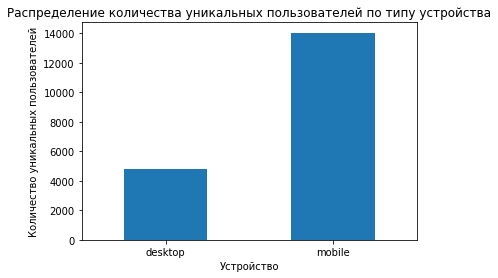

In [99]:
# строим столбачтую диаграмму по количеству уникальных пользователей по типу устройства
counts_users = df_autumn.groupby('device_type_canonical')['user_id'].nunique()
counts_users.plot(kind='bar', title='Распределение количества уникальных пользователей по типу устройства', 
                  xlabel='Устройство', ylabel='Количество уникальных пользователей', rot=0)
plt.show()

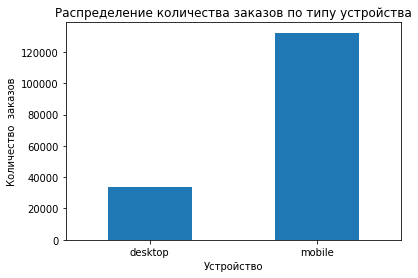

In [100]:
counts_orders = df_autumn.groupby('device_type_canonical')['order_id'].nunique()
counts_orders.plot(kind='bar', title='Распределение количества заказов по типу устройства', 
                   xlabel='Устройство', ylabel='Количество  заказов', rot=0)
plt.show()

Количество уникальных пользователей и заказов среди мобильных и стационарных устройств сильно отличается

In [101]:
group_desktop_orders = df_autumn_group[df_autumn_group['device_type_canonical']=='desktop']
group_mobile_orders = df_autumn_group[df_autumn_group['device_type_canonical']=='mobile']

<Figure size 504x216 with 0 Axes>

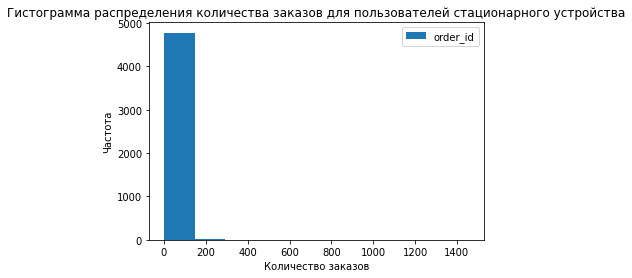

In [102]:
# строим гистограмму по количеству заказов для пользователей стационарного устройства
plt.figure(figsize=(7, 3))
group_desktop_orders.plot(
                kind='hist')
plt.title('Гистограмма распределения количества заказов для пользователей стационарного устройства')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

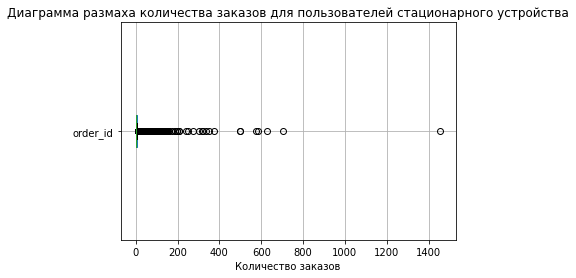

In [103]:
# Строим диаграмму размаха по количеству заказов для пользователей стационарного устройства
group_desktop_orders.boxplot(column='order_id', vert=False)
plt.title('Диаграмма размаха количества заказов для пользователей стационарного устройства')
plt.xlabel('Количество заказов')
plt.show()

<Figure size 504x216 with 0 Axes>

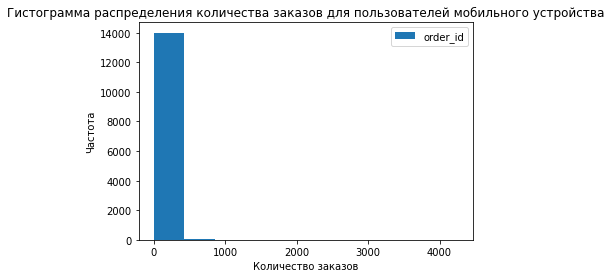

In [104]:
# строим гистограмму по количеству заказов для пользователей мобильного устройства
plt.figure(figsize=(7, 3))
group_mobile_orders.plot(
                kind='hist')
plt.title('Гистограмма распределения количества заказов для пользователей мобильного устройства')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

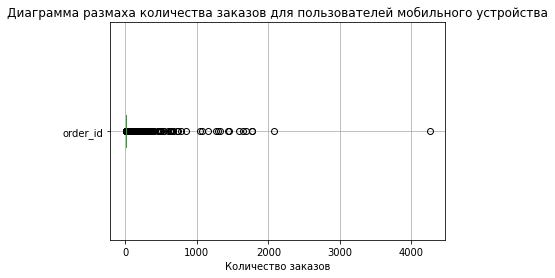

In [105]:
# Строим диаграмму размаха для пользователей мобильного устройства
group_mobile_orders.boxplot(column='order_id', vert=False)
plt.title('Диаграмма размаха количества заказов для пользователей мобильного устройства')
plt.xlabel('Количество заказов')
plt.show()

Графики выше показывают, что распределение количества заказов не является нормальным, есть слишком большие значения

Поскольку данные не распределены нормально, то следует использовать непараметрический тест Манна-Уитни, так как он не требует предположений о нормальности

In [120]:
# проводим тест манна-уитни
group_desktop = df_autumn_group[df_autumn_group['device_type_canonical']=='desktop']['order_id']
group_mobile = df_autumn_group[df_autumn_group['device_type_canonical']=='mobile']['order_id']

mw_test = mannwhitneyu(group_desktop, group_mobile, alternative='less') # гипотеза левостронняя, так как µ1<µ2
print(f'p-value={mw_test.pvalue}')

p-value=1.4497866772498109e-07


Полученное р-значение<0.05, таким образом, удается отвергнуть нулевую гипотезу и утверждать, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств

Вторая гипотеза
- нулевая гипотеза: среднее время между заказами пользователей мобильных приложений не отличается по сравнению с пользователями стационарных устройств
- альтернативная гипотеза: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств

In [107]:
# сортируем датафрейм по дате, выделяем разницу между датами заказов
df_autumn = df_autumn.sort_values(by=['user_id', 'created_ts_msk'])
df_autumn['delta_time'] = df_autumn.groupby('user_id')['created_ts_msk'].diff()
display(df_autumn[['user_id', 'created_ts_msk', 'delta_time']])

,user_id,created_ts_msk,delta_time
2,0005ca5e93f2cf4,2024-10-06 13:56:02,NaT
4,000898990054619,2024-10-04 22:33:15,NaT
5,000898990054619,2024-10-23 15:12:00,18 days 16:38:45
7,000a55a418c128c,2024-09-29 19:39:12,NaT
8,000a55a418c128c,2024-10-15 10:29:04,15 days 14:49:52
...,...,...,...
280625,fffcd3dde79eb2c,2024-10-27 17:54:52,1 days 00:11:29
280626,fffcd3dde79eb2c,2024-10-27 18:00:57,0 days 00:06:05
280627,fffcd3dde79eb2c,2024-10-30 13:37:43,2 days 19:36:46
280628,fffeeb3c120cf0b,2024-09-24 10:07:42,NaT


In [108]:
# переводим секунды в часы в разнице между датами заказов
df_autumn['delta_time_in_hours'] = df_autumn['delta_time'].dt.total_seconds()/3600
display(df_autumn[['user_id', 'created_ts_msk', 'delta_time', 'delta_time_in_hours']])

,user_id,created_ts_msk,delta_time,delta_time_in_hours
2,0005ca5e93f2cf4,2024-10-06 13:56:02,NaT,NaN
4,000898990054619,2024-10-04 22:33:15,NaT,NaN
5,000898990054619,2024-10-23 15:12:00,18 days 16:38:45,448.645833
7,000a55a418c128c,2024-09-29 19:39:12,NaT,NaN
8,000a55a418c128c,2024-10-15 10:29:04,15 days 14:49:52,374.831111
...,...,...,...,...
280625,fffcd3dde79eb2c,2024-10-27 17:54:52,1 days 00:11:29,24.191389
280626,fffcd3dde79eb2c,2024-10-27 18:00:57,0 days 00:06:05,0.101389
280627,fffcd3dde79eb2c,2024-10-30 13:37:43,2 days 19:36:46,67.612778
280628,fffeeb3c120cf0b,2024-09-24 10:07:42,NaT,NaN


In [109]:
# удаляем строки, где разница между датами является пропуском, то есть пользователь не совершал повторные заказы
df_autumn = df_autumn.dropna(subset=['delta_time_in_hours'])
display(df_autumn[['user_id', 'created_ts_msk', 'delta_time', 'delta_time_in_hours']])

,user_id,created_ts_msk,delta_time,delta_time_in_hours
5,000898990054619,2024-10-23 15:12:00,18 days 16:38:45,448.645833
8,000a55a418c128c,2024-10-15 10:29:04,15 days 14:49:52,374.831111
28,001e7037d013f0f,2024-09-29 22:58:14,13 days 01:44:57,313.749167
33,00245c702bc343e,2024-10-25 12:34:20,29 days 14:10:08,710.168889
35,0028d17a676f8c8,2024-10-06 00:35:19,28 days 03:33:16,675.554444
...,...,...,...,...
280623,fffcd3dde79eb2c,2024-10-22 13:46:24,5 days 15:57:51,135.964167
280624,fffcd3dde79eb2c,2024-10-26 17:43:23,4 days 03:56:59,99.949722
280625,fffcd3dde79eb2c,2024-10-27 17:54:52,1 days 00:11:29,24.191389
280626,fffcd3dde79eb2c,2024-10-27 18:00:57,0 days 00:06:05,0.101389


In [110]:
# группируем данные по устройству и по пользователям, считаем среднее время между заказами
group_delta_time = df_autumn.groupby(['device_type_canonical', 'user_id'])['delta_time_in_hours'].mean().reset_index()
display(group_delta_time)

,device_type_canonical,user_id,delta_time_in_hours
0,desktop,002b75ca606ba46,169.428333
1,desktop,005fefeabf1e678,0.371806
2,desktop,006d1660d830822,187.581806
3,desktop,009201290d7316b,211.226667
4,desktop,00937de412ea430,9.989167
...,...,...,...
11871,mobile,ffe364dd8211157,0.467500
11872,mobile,ffe73c50cbd71fc,2.183056
11873,mobile,ffed3ff067d4f12,552.381389
11874,mobile,fff13b79bd47d7c,401.267500


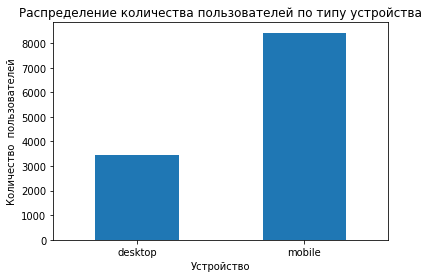

In [111]:
counts_users_time = group_delta_time.groupby('device_type_canonical')['user_id'].nunique()
counts_users_time.plot(kind='bar', title='Распределение количества пользователей по типу устройства', 
                   xlabel='Устройство', ylabel='Количество  пользователей', rot=0)
plt.show()

Пользователей мобильных устройств намного больше, чем пользователей стационарных

In [112]:
group_desktop_time = group_delta_time[group_delta_time['device_type_canonical']=='desktop']
group_mobile_time = group_delta_time[group_delta_time['device_type_canonical']=='mobile']

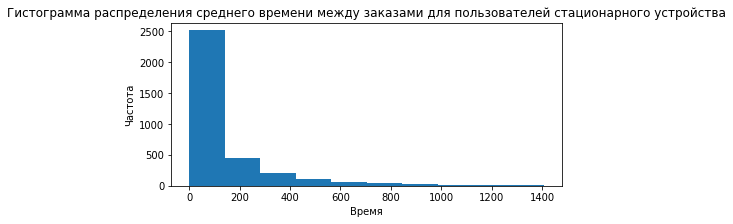

In [113]:
# строим гистограмму по среднему времени между заказами
plt.figure(figsize=(7, 3))
group_desktop_time['delta_time_in_hours'].plot(
                kind='hist')
plt.title('Гистограмма распределения среднего времени между заказами для пользователей стационарного устройства')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

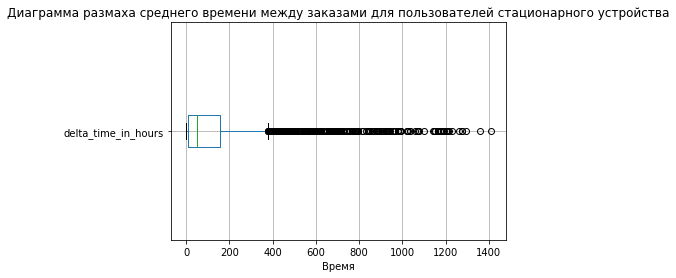

In [114]:
# Строим диаграмму размаха для пользователей мобильного устройства
group_desktop_time.boxplot(column='delta_time_in_hours', vert=False)
plt.title('Диаграмма размаха среднего времени между заказами для пользователей стационарного устройства')
plt.xlabel('Время')
plt.show()

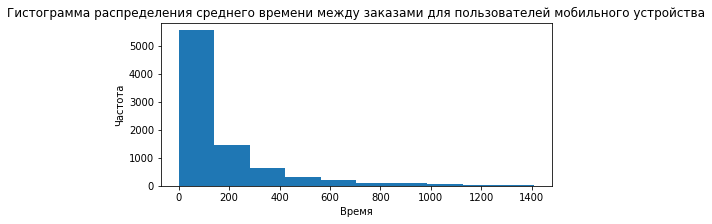

In [115]:
# строим гистограмму по среднему времени между заказами
plt.figure(figsize=(7, 3))
group_mobile_time['delta_time_in_hours'].plot(
                kind='hist')
plt.title('Гистограмма распределения среднего времени между заказами для пользователей мобильного устройства')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

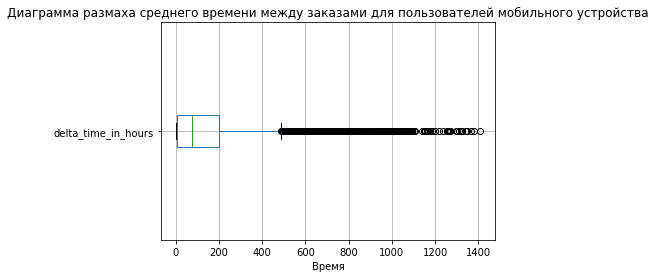

In [116]:
# Строим диаграмму размаха для пользователей мобильного устройства
group_mobile_time.boxplot(column='delta_time_in_hours', vert=False)
plt.title('Диаграмма размаха среднего времени между заказами для пользователей мобильного устройства')
plt.xlabel('Время')
plt.show()

В данных наблюдается много выбросов, распределение не является нормальным, следует использовать непараметрический тест Манна-Уитни

In [118]:
# применяем тест манна-уитни для проверки гипотезы
group_m_time = group_delta_time[group_delta_time['device_type_canonical']=='mobile']['delta_time_in_hours']
group_d_time = group_delta_time[group_delta_time['device_type_canonical']=='desktop']['delta_time_in_hours']

mw_test = mannwhitneyu(group_d_time, group_m_time, alternative='greater') # гипотеза правостронняя
print(f'p-value={mw_test.pvalue}')

p-value=0.9999999998371318


p=значение>0.05, соответственно, у нас нет достаточных оснований, чтобы отвергнуть нулевую гипотезу, значит делаем вывод о том, что среднее время между заказами пользователей мобильных приложений не отличается по сравнению с пользователями стационарных устройств

## 5. Общий вывод и рекомендации

Был проведен анализ на основе данных сервиса Яндекс Афиша за период с 1 июня по 30 октября 2024 года.   

Начальной процедурой являлись предобработка данных и подготовка их к исследованию, в ходе которых проверялось наличие пропусков и дубликатов (было удалено 38 неявных дубликатов в датафрейме с информацией о заказах и 871 неявный дубликат в датафрейме с информацией о мероприятиях), изучение категориальных и количественных значений, вследствие чего данные столбцов revenue, ticket_count, total были отфильтрованы по 99му процентилю из-за наличия выбросов. Также было осуществлено преобразование типов данных и снижение размерности. Поскольку данные представлены в двух валютах, то была проведена конвертация валют.  

Исследовательский анализ данных позволил проанализировать метрики по месяцам, было рассчитано количество заказов по каждому месяцу, этот показатель увеличивался от июня к ноябрю. Также осуществлялось сравнение осеннего и летнего периодов, осенью показатель количества заказов был выше (и по типу мероприятия, и по типу устройства, и по возрастному рейтингу). Относительное изменение осенних значений по сравнению с летними показал, что наибольшая доля выручки с продажи одного билета принадлежит такому типу мероприятий, как стендап, наименьшая - театр.   

Далее было изучено изменение осенней активности пользователей по дням. Общее число заказов достигло наибольшего значения (6.850) 1 октября, наименьшее значение (746) было зафиксировано 1 сентября. На протяжении всего периода метрика в целом довольно стабильна, находилась в районе 2000-4000. Резкий подъем замечен в последний день (5.663). Линейный график изменения количества активных пользователей позволил сделать следующие выводы: на протяжении всего периода значение увеличивалось, достигнув максимального значения (1.105) в последний день. Минимальное значение (218) принадлежит первому дню.  Линейный график среднего числа заказов на одного пользователя имеет два пика: 3 сентября (10.57) и 1 октября (7.57).  

Изучение недельной цикличности показало, что низкая активность замечена в воскресенье, высокая - во вторник и четверг, в связи с этим можно было бы различными предложениями повысить активность пользователей в выходные. Лидерами среди регионов по количеству мероприятий и заказов являются Каменевский район и Североярская область, соотственно, можно было бы сфокусировать внимание на менее успешных регионах, чтобы удовлетворить спрос там.   

Статистический анализ включал в себя проверку двух гипотез. Первая была связана со средним количеством заказов на одного пользователя по типу устройств. Получив р-значение (<0.05) удалось отвергнуть нулевую гипотезу и выдвинуть тезис о том, что среднее количество заказов на одного пользователя мобильного приложения выше, чем пользователя стационарного устройства. 
Вторая гипотеза была связана со средним временем между заказами пользователей разных устройств. Полученное р-значение (>0.05) не позволило отвернуть нулевую гипотезу, был сделан вывод о том, что среднее время между заказали пользователей мобильных приложений не отличается от среднего времени между заказами пользователей стационарных устройств.  

Итог:  
Осень показала более высокие показатели по сравнению с летом, что может быть связано с увеличением числа мероприятий или улучшением их качества. Это может быть полезным для планирования будущих мероприятий и маркетинговых стратегий.
  
Стендап-мероприятия приносят наибольшую выручку на билет, что может указывать на предпочтения пользователей. Рекомендуется больше инвестировать в подобные мероприятия и рассмотреть возможность увеличения их количества.
  
Поскольку пользователи мобильных приложений совершают больше заказов, стоит продолжать улучшать функциональность и удобство использования приложения, возможно, внедрять новые функции или предложения, чтобы удерживать пользователей.